# Bradley-Terry-Luce Model 

## Dummy data

In [1]:
import pandas as pd
import numpy as np

df = pd.DataFrame({
    'A': [np.nan, 3, 0, 4],
    'B': [2, np.nan, 3, 0],
    'C': [0, 5, np.nan, 3],
    'D': [1, 0, 1, np.nan]
}, index=['A', 'B', 'C', 'D'])

df

,A,B,C,D
A,NaN,2.0,0.0,1.0
B,3.0,NaN,5.0,0.0
C,0.0,3.0,NaN,1.0
D,4.0,0.0,3.0,NaN


In [65]:
def get_estimate(i, p, df):
    get_prob = lambda i, j: np.nan if i == j else p.iloc[i] + p.iloc[j]
    n = df.iloc[i].sum()
    
    d_n = df.iloc[i] + df.iloc[:, i]
    d_d = pd.Series([get_prob(i, j) for j in range(len(p))], index=p.index)
    d = (d_n / d_d).sum()
    
    return n / d

def estimate_p(p, df):
    return pd.Series([estimate(i, p, df) for i in range(df.shape[0])], index=p.index)


def iterate(df, p=None, n=20, sorted=True):
    if p is None:
        p = pd.Series([1 for _ in range(df.shape[0])], index=list(df.columns))
        
    estimates = [p]
    
    for _ in range(n):
        p = estimate_p(p, df)
        p = p / p.sum()
        estimates.append(p)
    
    p = p.sort_values(ascending=False) if sorted else p
    return p, pd.DataFrame(estimates)

p, estimates = iterate(df, n=100)

In [66]:
p

D    0.492133
B    0.226152
C    0.143022
A    0.138692
dtype: float64

In [67]:
estimates.tail()

,A,B,C,D
96,0.138692,0.226152,0.143022,0.492133
97,0.138692,0.226152,0.143022,0.492133
98,0.138692,0.226152,0.143022,0.492133
99,0.138692,0.226152,0.143022,0.492133
100,0.138692,0.226152,0.143022,0.492133


## NFL data

In [185]:
def get_winner(r):
    if r.score1 > r.score2:
        return r.team1
    elif r.score1 < r.score2:
        return r.team2
    else:
        return np.nan
    
def get_loser(r):
    if r.score1 > r.score2:
        return r.team2
    elif r.score1 < r.score2:
        return r.team1
    else:
        return np.nan
    
nfl = pd.read_csv('./nfl/2021.csv')
nfl['team1'] = nfl['team1'].apply(lambda s: s.strip())
nfl['team2'] = nfl['team2'].apply(lambda s: s.strip())
nfl = nfl.drop_duplicates()
nfl['winner'] = nfl.apply(get_winner, axis=1)
nfl['loser'] = nfl.apply(get_loser, axis=1)

nfl.head()

,team1,team2,score1,score2,winner,loser
0,Steelers,Bills,23,16,Steelers,Bills
1,Bills,Dolphins,35,0,Bills,Dolphins
2,Washington,Bills,21,43,Bills,Washington
3,Texans,Bills,0,40,Bills,Texans
4,Bills,Chiefs,38,20,Bills,Chiefs


In [186]:
nfl[nfl.winner == 'Patriots']

,team1,team2,score1,score2,winner,loser
12,Patriots,Jets,25,6,Patriots,Jets
15,Patriots,Texans,25,22,Patriots,Texans
17,Jets,Patriots,13,54,Patriots,Jets
18,Patriots,Chargers,27,24,Patriots,Chargers
19,Patriots,Panthers,24,6,Patriots,Panthers
20,Browns,Patriots,7,45,Patriots,Browns
21,Patriots,Falcons,25,0,Patriots,Falcons


In [187]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

w = nfl.winner.value_counts().sort_index()
l = nfl.loser.value_counts().sort_index()

wl_df = pd.DataFrame([w, l]).T.rename(columns={'winner': 'wins', 'loser': 'losses'})
wl_df['n'] = wl_df.wins + wl_df.losses
wl_df

,wins,losses,n
49ers,5.0,5.0,10.0
Bears,4.0,7.0,11.0
Bengals,6.0,4.0,10.0
Bills,8.0,4.0,12.0
Broncos,6.0,5.0,11.0
Browns,6.0,5.0,11.0
Buccaneers,7.0,3.0,10.0
Cardinals,9.0,2.0,11.0
Chargers,6.0,4.0,10.0
Chiefs,7.0,4.0,11.0


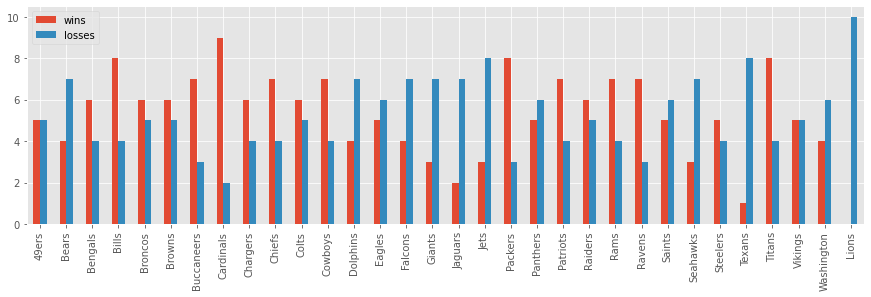

In [188]:
_ = wl_df[['wins', 'losses']].plot(kind='bar', figsize=(15, 4))

In [189]:
teams = sorted(list(set(nfl.team1) | set(nfl.team2)))
t2i = {t: i for i, t in enumerate(teams)}

df = nfl\
    .groupby(['winner', 'loser'])\
    .agg('count')\
    .drop(columns=['team2', 'score1', 'score2'])\
    .rename(columns={'team1': 'n'})\
    .reset_index()
df['r'] = df['winner'].apply(lambda t: t2i[t])
df['c'] = df['loser'].apply(lambda t: t2i[t])

n_teams = len(teams)
mat = np.zeros([n_teams, n_teams])

for _, r in df.iterrows():
    mat[r.r, r.c] = r.n
    
df = pd.DataFrame(mat, columns=teams, index=teams)

In [190]:
p, estimates = iterate(df, n=100)

In [191]:
p

Cardinals     0.112706
Packers       0.070977
Chiefs        0.064050
Ravens        0.058590
Chargers      0.053084
Titans        0.050749
Cowboys       0.048864
Buccaneers    0.045425
Bills         0.041165
Steelers      0.038719
Rams          0.034876
Raiders       0.034618
Bengals       0.032372
Patriots      0.031630
Vikings       0.031109
Browns        0.030936
Broncos       0.028443
Colts         0.024283
49ers         0.021809
Saints        0.019569
Eagles        0.018983
Washington    0.018483
Panthers      0.015128
Seahawks      0.012743
Giants        0.011149
Bears         0.010714
Dolphins      0.010655
Falcons       0.009572
Jets          0.007794
Jaguars       0.007411
Texans        0.003394
Lions         0.000000
dtype: float64